# Score Prediction with Emotion and Topic Signals

Refactored workflow to clean the data, engineer NRCLex emotions and Empath topics, and train a RandomForest regressor to predict score.

## Categorization Structure
- **Emotion categories:** anger, fear, anticipation, trust, surprise, sadness, joy, disgust
- **Topic categories:** violence, politics, religion, humanitarian, personal_narrative

Each section below mirrors the required methodology and logs shapes/columns after transformations.

## 0. Setup and Load Data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import display

# Optional installs (uncomment if needed in your environment)
!pip install nrclex empath scikit-learn

DATA_PATH = Path('/Users/ishaanbal/Desktop/DSC161_FinalProject/reddit_opinion_PSE_ISR.csv')

try:
    df_raw = pd.read_csv(DATA_PATH, low_memory=False)
    print(f'Loaded dataset from {DATA_PATH}')
    print('Initial shape:', df_raw.shape)
    print('Initial columns:', list(df_raw.columns))
    display(df_raw.head())
except FileNotFoundError:
    raise FileNotFoundError(f'CSV not found at {DATA_PATH}. Update DATA_PATH if the file is elsewhere.')

Loaded dataset from /Users/ishaanbal/Desktop/DSC161_FinalProject/reddit_opinion_PSE_ISR.csv
Initial shape: (3518485, 24)
Initial columns: ['comment_id', 'score', 'self_text', 'subreddit', 'created_time', 'post_id', 'author_name', 'controversiality', 'ups', 'downs', 'user_is_verified', 'user_account_created_time', 'user_awardee_karma', 'user_awarder_karma', 'user_link_karma', 'user_comment_karma', 'user_total_karma', 'post_score', 'post_self_text', 'post_title', 'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received', 'post_created_time']
Loaded dataset from /Users/ishaanbal/Desktop/DSC161_FinalProject/reddit_opinion_PSE_ISR.csv
Initial shape: (3518485, 24)
Initial columns: ['comment_id', 'score', 'self_text', 'subreddit', 'created_time', 'post_id', 'author_name', 'controversiality', 'ups', 'downs', 'user_is_verified', 'user_account_created_time', 'user_awardee_karma', 'user_awarder_karma', 'user_link_karma', 'user_comment_karma', 'user_total_karma', 'post_score', 'post_sel

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,user_link_karma,user_comment_karma,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time
0,nricdgq,1,Israel left in 2005.\n\nThe blockade was estab...,worldnews,2025-11-30 07:56:18,1pa8zi8,AlbertWhiterose,0,1,0,...,5776.0,22148.0,27924.0,210,NaN,U.S. 'New Gaza' initiative seeks to move 2 mil...,0.81,210,0,2025-11-30 04:19:38
1,nriccrn,1,Gaza had 20 years and millions in aid money to...,worldnews,2025-11-30 07:56:06,1pa8zi8,xyzqvc,0,1,0,...,5.0,47403.0,47408.0,210,NaN,U.S. 'New Gaza' initiative seeks to move 2 mil...,0.81,210,0,2025-11-30 04:19:38
2,nricc9d,1,It's not genocidal and there really is no colo...,IsraelPalestine,2025-11-30 07:55:57,1p9wwd4,AsaxenaSmallwood04,0,1,0,...,26.0,8269.0,8295.0,23,“Lending full backing to the Border Police and...,Why is Ben Gvir celebrating the two unarmed me...,0.78,23,0,2025-11-29 19:03:38
3,nric51c,1,Israel has expelled Palestinians from half of ...,IsraelPalestine,2025-11-30 07:53:51,1p9nsbb,OggiSbugiardo,0,1,0,...,1485.0,10524.0,12009.0,1,This proposed peace plan is intended to be bot...,"Please rate this ""soft landing"" peace plan",0.55,1,0,2025-11-29 12:28:43
4,nribzfv,1,I missed genocidal too. Also saying colonisati...,IsraelPalestine,2025-11-30 07:52:14,1p9wwd4,Unpoppable99,0,1,0,...,53.0,339.0,392.0,23,“Lending full backing to the Border Police and...,Why is Ben Gvir celebrating the two unarmed me...,0.78,23,0,2025-11-29 19:03:38


## 1. Data Cleaning
- Keep only the required columns to reduce noise and memory use.
- Prepare `post_score` placeholder for posts that lack a parent score.

In [2]:
required_cols = [
    'post_id', 'comment_id', 'score', 'self_text', 'subreddit', 'created_time',
    'ups', 'post_score', 'post_upvote_ratio', 'post_created_time'
]

# Ensure all required columns exist
for col in required_cols:
    if col not in df_raw.columns:
        df_raw[col] = pd.NA

# Retain only the required columns
keep_df = df_raw[required_cols].copy()

# Normalize numeric columns
numeric_cols = ['score', 'ups', 'post_score', 'post_upvote_ratio']
for col in numeric_cols:
    keep_df[col] = pd.to_numeric(keep_df[col], errors='coerce')

print('After cleaning shape:', keep_df.shape)
print('Columns after cleaning:', list(keep_df.columns))
keep_df.head()

After cleaning shape: (3518485, 10)
Columns after cleaning: ['post_id', 'comment_id', 'score', 'self_text', 'subreddit', 'created_time', 'ups', 'post_score', 'post_upvote_ratio', 'post_created_time']


,post_id,comment_id,score,self_text,subreddit,created_time,ups,post_score,post_upvote_ratio,post_created_time
0,1pa8zi8,nricdgq,1,Israel left in 2005.\n\nThe blockade was estab...,worldnews,2025-11-30 07:56:18,1,210,0.81,2025-11-30 04:19:38
1,1pa8zi8,nriccrn,1,Gaza had 20 years and millions in aid money to...,worldnews,2025-11-30 07:56:06,1,210,0.81,2025-11-30 04:19:38
2,1p9wwd4,nricc9d,1,It's not genocidal and there really is no colo...,IsraelPalestine,2025-11-30 07:55:57,1,23,0.78,2025-11-29 19:03:38
3,1p9nsbb,nric51c,1,Israel has expelled Palestinians from half of ...,IsraelPalestine,2025-11-30 07:53:51,1,1,0.55,2025-11-29 12:28:43
4,1p9wwd4,nribzfv,1,I missed genocidal too. Also saying colonisati...,IsraelPalestine,2025-11-30 07:52:14,1,23,0.78,2025-11-29 19:03:38


## 2. Feature Engineering
- NRCLex emotion scores for 8 categories
- Empath topic scores for violence, politics, religion, humanitarian, personal_narrative
- Sample 30,000 rows for feature extraction to keep runtime manageable (adjust `SAMPLE_SIZE` as needed)
- Temporal signals from `created_time`
- Comment indicator + `post_score` imputation
- Missing values for engineered features filled with 0

In [4]:
from nrclex import NRCLex
from empath import Empath

SAMPLE_SIZE = 30000  # sample size for NRCLex/Empath feature extraction

# Sample rows to speed up feature engineering
sample_n = min(SAMPLE_SIZE, len(keep_df))
df_feat = keep_df.sample(sample_n, random_state=42).reset_index(drop=True)
print(f'Feature engineering on sample of {sample_n} rows (out of {len(keep_df)})')

text_col = 'self_text'

# Safe text helper
def to_text(val: object) -> str:
    if pd.isna(val):
        return ''
    return str(val)

# NRCLex emotion extraction
emotion_categories = ['anger', 'fear', 'anticipation', 'trust', 'surprise', 'sadness', 'joy', 'disgust']

def nrc_emotions(text: str):
    if not text.strip():
        return {f'emotion_{c}': 0.0 for c in emotion_categories}
    lex = NRCLex(text)
    scores = lex.raw_emotion_scores
    total = sum(scores.values()) or 1.0
    return {f'emotion_{c}': float(scores.get(c, 0.0)) / total for c in emotion_categories}

emotion_df = df_feat[text_col].fillna('').apply(lambda t: nrc_emotions(to_text(t))).apply(pd.Series)

# Empath topic extraction
empath_categories = ['violence', 'politics', 'religion', 'humanitarian', 'personal_narrative']
lexicon = Empath()

def empath_topics(text: str):
    if not text.strip():
        return {f'topic_{c}': 0.0 for c in empath_categories}
    res = lexicon.analyze(text, normalize=True)
    return {f'topic_{c}': float(res.get(c, 0.0)) for c in empath_categories}

empath_df = df_feat[text_col].fillna('').apply(lambda t: empath_topics(to_text(t))).apply(pd.Series)

# Combine engineered features
engineered_df = pd.concat([df_feat, emotion_df, empath_df], axis=1)

# Indicator for comments vs original posts
engineered_df['is_comment'] = engineered_df['comment_id'].notna().astype(int)

# Impute post_score for original posts and other missing numeric data
engineered_df['post_score'] = engineered_df['post_score'].fillna(0)
engineered_df['post_upvote_ratio'] = engineered_df['post_upvote_ratio'].fillna(0)

# Parse created_time to datetime and derive hour/day-of-week
raw_time = engineered_df['created_time']
if pd.api.types.is_numeric_dtype(raw_time):
    created_dt = pd.to_datetime(raw_time, unit='s', errors='coerce')
else:
    created_dt = pd.to_datetime(raw_time, errors='coerce')
engineered_df['created_dt'] = created_dt
engineered_df['hour'] = engineered_df['created_dt'].dt.hour.fillna(-1).astype(int)
engineered_df['day_of_week'] = engineered_df['created_dt'].dt.dayofweek.fillna(-1).astype(int)

# Replace any lingering NaN values in engineered features
engineered_cols = list(emotion_df.columns) + list(empath_df.columns) + ['hour', 'day_of_week', 'is_comment']
engineered_df[engineered_cols] = engineered_df[engineered_cols].fillna(0)

print('After feature engineering shape:', engineered_df.shape)
print('Columns after feature engineering:', list(engineered_df.columns))

sample_cols = [text_col, 'score', 'post_score', 'post_upvote_ratio', 'is_comment', 'hour', 'day_of_week'] + list(emotion_df.columns[:3]) + list(empath_df.columns[:2])
display(engineered_df[sample_cols].head())

Feature engineering on sample of 30000 rows (out of 3518485)
After feature engineering shape: (30000, 27)
Columns after feature engineering: ['post_id', 'comment_id', 'score', 'self_text', 'subreddit', 'created_time', 'ups', 'post_score', 'post_upvote_ratio', 'post_created_time', 'emotion_anger', 'emotion_fear', 'emotion_anticipation', 'emotion_trust', 'emotion_surprise', 'emotion_sadness', 'emotion_joy', 'emotion_disgust', 'topic_violence', 'topic_politics', 'topic_religion', 'topic_humanitarian', 'topic_personal_narrative', 'is_comment', 'created_dt', 'hour', 'day_of_week']


,self_text,score,post_score,post_upvote_ratio,is_comment,hour,day_of_week,emotion_anger,emotion_fear,emotion_anticipation,topic_violence,topic_politics
0,"People use the term out of ignorance, but also...",4,453,0.81,1,23,5,0.026316,0.105263,0.052632,0.003650,0.000000
1,also all of your articles are from israeli bac...,-1,0,0.31,1,7,6,0.086957,0.086957,0.130435,0.022222,0.000000
2,Oh please. And what about the Muslim brotherho...,7,0,0.23,1,7,3,0.111111,0.083333,0.083333,0.007634,0.007634
3,Mana is money and no one will counter my proof,2,1096,0.91,1,22,6,0.142857,0.000000,0.142857,0.000000,0.000000
4,Russia will delay food supplies and then have ...,7,207,0.90,1,2,3,0.142857,0.071429,0.000000,0.000000,0.000000


## 3. Feature Set for Prediction
- Target: `score`
- Predictors: subreddit (one-hot), temporal features, post_score (0 for original posts), post_upvote_ratio, NRCLex emotions, Empath topics, comment indicator
- Drop rows missing the target.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

model_df = engineered_df.dropna(subset=['score']).copy()

categorical_features = ['subreddit']
numeric_features = ['post_score', 'post_upvote_ratio', 'hour', 'day_of_week', 'is_comment'] + list(emotion_df.columns) + list(empath_df.columns)

X = model_df[categorical_features + numeric_features]
y = model_df['score']

print('Modeling data shape:', X.shape)
print('Predictor columns:', X.columns.tolist())

Modeling data shape: (30000, 19)
Predictor columns: ['subreddit', 'post_score', 'post_upvote_ratio', 'hour', 'day_of_week', 'is_comment', 'emotion_anger', 'emotion_fear', 'emotion_anticipation', 'emotion_trust', 'emotion_surprise', 'emotion_sadness', 'emotion_joy', 'emotion_disgust', 'topic_violence', 'topic_politics', 'topic_religion', 'topic_humanitarian', 'topic_personal_narrative']


## 4. Model Construction and Training
- 80/20 train-test split (`random_state=42`)
- Standardize numeric features
- One-hot encode subreddit
- RandomForestRegressor as final estimator

In [6]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_features),
        ('numeric', numeric_transformer, numeric_features)
    ],
    remainder='drop'
)

rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)

pipeline = Pipeline(steps=[('preprocess', preprocess), ('model', rf_model)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print('Train shape:', X_train.shape, '| Test shape:', X_test.shape)

pipeline.fit(X_train, y_train)
print('Model training complete.')

Train shape: (24000, 19) | Test shape: (6000, 19)
Model training complete.


## 5. Evaluation and Feature Importance
- Metrics: MAE, RMSE, R²
- Feature importances sorted by importance

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

preds = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

metrics_df = pd.DataFrame([
    {'metric': 'MAE', 'value': mae},
    {'metric': 'RMSE', 'value': rmse},
    {'metric': 'R^2', 'value': r2}
])

print('Evaluation metrics:')
display(metrics_df.style.format({'value': '{:.4f}'}))

# Feature importances
preprocessor = pipeline.named_steps['preprocess']
feature_names = preprocessor.get_feature_names_out()
importances = pipeline.named_steps['model'].feature_importances_
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False)

print('Top feature importances:')
display(fi_df.head(20))

/Users/ishaanbal/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluation metrics:


,metric,value
0,MAE,36.6802
1,RMSE,163.0502
2,R^2,-0.1599


Top feature importances:


,feature,importance
14,numeric__post_score,0.267322
16,numeric__hour,0.133277
25,numeric__emotion_joy,0.124025
15,numeric__post_upvote_ratio,0.099871
17,numeric__day_of_week,0.062975
21,numeric__emotion_anticipation,0.058016
22,numeric__emotion_trust,0.047378
23,numeric__emotion_surprise,0.037994
20,numeric__emotion_fear,0.033381
24,numeric__emotion_sadness,0.031575


## 6. Visualization
Supplementary plots for model diagnostics and feature importance.

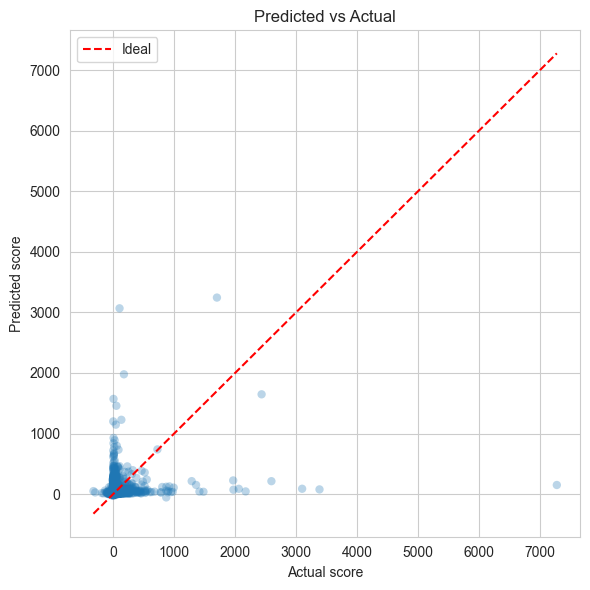

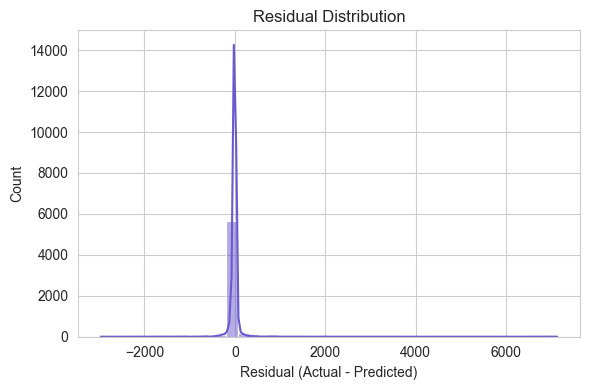

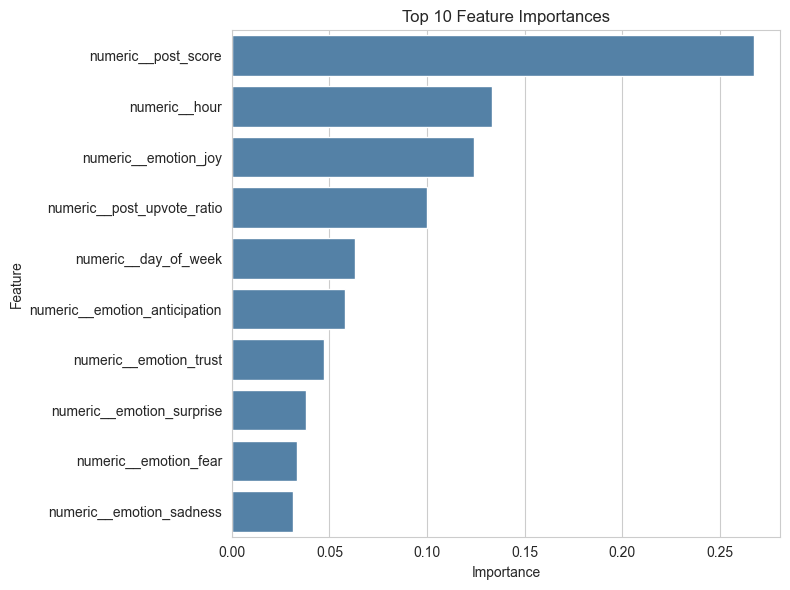

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# 1) Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.3, edgecolor='none')
lim = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
plt.plot(lim, lim, color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual score')
plt.ylabel('Predicted score')
plt.title('Predicted vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Residual distribution
residuals = y_test - preds
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True, color='slateblue')
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

# 3) Top feature importances (visual)
top_n = 10
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=fi_df.head(top_n), color='steelblue')
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 7. Feature Importance by Category
Tables for emotions and topics, plus a visualization for other predictors (post score, timing, subreddit, etc.).

Emotion feature importances:


,feature,importance
25,numeric__emotion_joy,0.124025
21,numeric__emotion_anticipation,0.058016
22,numeric__emotion_trust,0.047378
23,numeric__emotion_surprise,0.037994
20,numeric__emotion_fear,0.033381
24,numeric__emotion_sadness,0.031575
26,numeric__emotion_disgust,0.019757
19,numeric__emotion_anger,0.017543


Topic feature importances:


,feature,importance
27,numeric__topic_violence,0.015431
29,numeric__topic_religion,0.004870
28,numeric__topic_politics,0.003983
30,numeric__topic_humanitarian,0.000000
31,numeric__topic_personal_narrative,0.000000


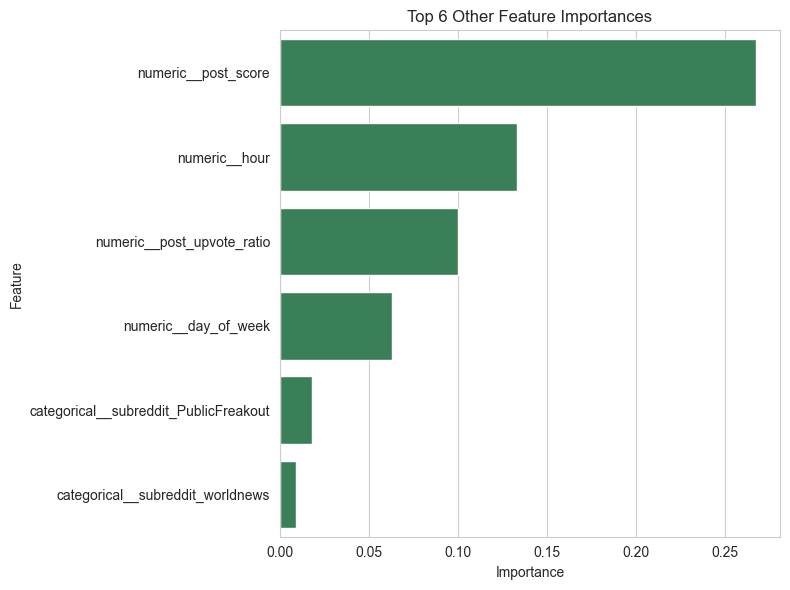

In [14]:
# Separate feature importances by category
fi_df = fi_df.sort_values('importance', ascending=False)

emotion_importances = fi_df[fi_df['feature'].str.contains('emotion')]
topic_importances = fi_df[fi_df['feature'].str.contains('topic')]
other_importances = fi_df[~fi_df['feature'].str.contains('emotion|topic')]

print('Emotion feature importances:')
display(emotion_importances)

print('Topic feature importances:')
display(topic_importances)

# Visualize other (non-emotion/topic) features
other_top_n = 6
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=other_importances.head(other_top_n), color='seagreen')
plt.title(f'Top {other_top_n} Other Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 8. Emotion and Topic Importance Plots
Visualize the emotion and topic feature importances.

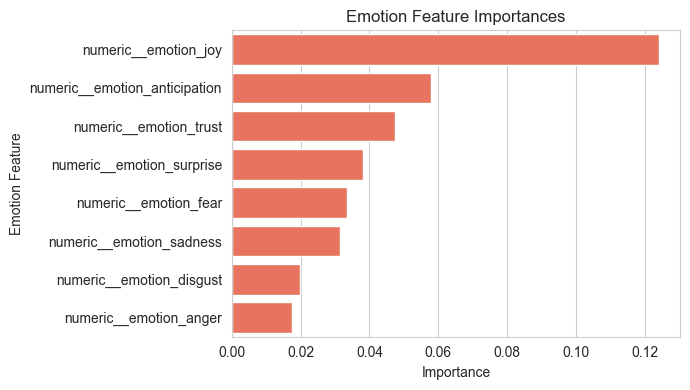

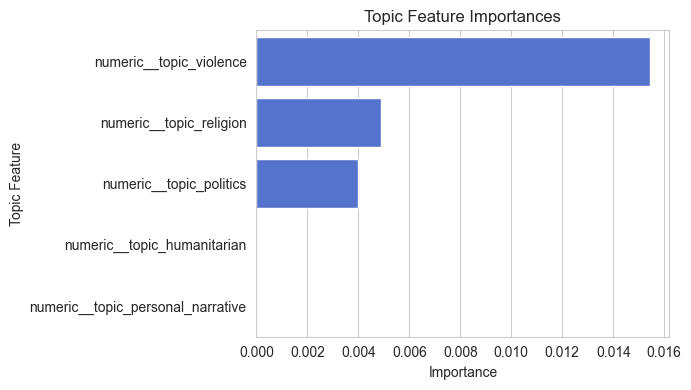

In [15]:
# Plot emotion and topic importances
plt.figure(figsize=(7,4))
sns.barplot(x='importance', y='feature', data=emotion_importances, color='tomato')
plt.title('Emotion Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Emotion Feature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(x='importance', y='feature', data=topic_importances, color='royalblue')
plt.title('Topic Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Topic Feature')
plt.tight_layout()
plt.show()

## 9. Classification-Style Metrics (Binarized Score)
Treat score as high vs. low using a threshold, then report accuracy, precision, recall, F1, and confusion matrix.

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Choose a threshold for high vs low score. Default: median of training data.
THRESHOLD = model_df['score'].median()

# Actual and predicted classes
actual_class = (y_test >= THRESHOLD).astype(int)
pred_class = (preds >= THRESHOLD).astype(int)

acc = accuracy_score(actual_class, pred_class)
prec, rec, f1, _ = precision_recall_fscore_support(actual_class, pred_class, average='binary', zero_division=0)
cm = confusion_matrix(actual_class, pred_class)

clf_metrics = pd.DataFrame([
    {'metric': 'Accuracy', 'value': acc},
    {'metric': 'Precision', 'value': prec},
    {'metric': 'Recall', 'value': rec},
    {'metric': 'F1', 'value': f1},
    {'metric': 'Threshold', 'value': THRESHOLD}
])

print('Classification-style metrics (score >= threshold considered positive):')
display(clf_metrics.style.format({'value': '{:.4f}'}))

cm_df = pd.DataFrame(cm, index=['Actual Low', 'Actual High'], columns=['Pred Low', 'Pred High'])
print('Confusion matrix:')
display(cm_df)

Classification-style metrics (score >= threshold considered positive):


,metric,value
0,Accuracy,0.6700
1,Precision,0.6350
2,Recall,0.8118
3,F1,0.7126
4,Threshold,3.0000


Confusion matrix:


,Pred Low,Pred High
Actual Low,1565,1411
Actual High,569,2455
